# Comprehensive EDA Report — Reviews Dataset

**Dataset description :** `df` with columns: `Product_Name`, `Date`, `Verified_Purchase`, `Review_Text`, `Rating`.


## Table of contents

1. Goals & deliverables
2. Environment & performance notes (handling 810k rows)
3. Data loading & preprocessing
4. Dataset overview statistics (code + plots + interpretation)
5. Rating-wise textual analysis (per-rating wordfreqs, wordclouds, top keywords, sentiment-heavy words)
6. Product-wise rating distribution and product-level summaries
7. Text statistics by rating (lengths, polarity, subjectivity, intensity)
8. Advanced NLP: aspect-based sentiment, NER, n-grams, topic modeling (LDA per rating)
9. Visualizations required (heatmaps, confusion matrix, ROC/PR, attention viz guidance)
10. Business recommendations & extra insights you can extract

## 1) Goals & deliverables

Deliver a reproducible EDA notebook and a narrative report including:

* Dataset overview statistics and missingness
* Rating distributions and time trends
* Per-rating text analysis (freqs, wordclouds, top 20 keywords, sentiment-heavy words)
* Product-level analyses (top products, 1-star/5-star concentrated products)
* Text statistics by rating (avg length, polarity, subjectivity, intensity)
* Advanced NLP insights: aspects, NER, n-grams, LDA topics per rating
* Visualizations: distribution plots, heatmaps, confusion matrices, ROC/PR curves
* Business recommendations and suggestions for further modelling


## 2) Data loading

In [23]:
import pandas as pd

df = pd.read_csv(
    r"C:\Users\kjnav\Documents\Navaneee\Automated-AI-Review-Rating-Prediction-System\data\kaggle\split_dataset_1.csv"
)
print(df.shape)
df.head(3)

(810000, 8)


,asin,Review_Text,Rating,Date,Verified_Purchase,Product_Name,Clean_Review,review_length
0,B00CV2M68E,The outer case is very rigid. And it came slig...,2,"12 5, 2014",False,E LV Armor Defender Protective Case for Samsun...,outer case rigid came slightly bowed place dep...,66
1,B005WYYYH4,I realized that I left a review for the phone ...,1,"11 25, 2012",True,Lg Vs700 Enlighten/ls700 Optimus Slider Rubber...,realized left review phone cover cover terribl...,37
2,B00N1WOY4W,"Great power bank, charges my Samsung phone ver...",5,"05 1, 2017",True,MAXOAK Portable Charger Power Bank External Ba...,great power bank charges samsung phone fast ch...,15


In [24]:
# selecting necessary columns.
df_selected = df[['asin','Product_Name', 'Date', 'Verified_Purchase', 'Review_Text', 'Rating']]
df_selected.head()
df=df_selected.copy()

In [25]:
#preview of data
df.head()

,asin,Product_Name,Date,Verified_Purchase,Review_Text,Rating
0,B00CV2M68E,E LV Armor Defender Protective Case for Samsun...,"12 5, 2014",False,The outer case is very rigid. And it came slig...,2
1,B005WYYYH4,Lg Vs700 Enlighten/ls700 Optimus Slider Rubber...,"11 25, 2012",True,I realized that I left a review for the phone ...,1
2,B00N1WOY4W,MAXOAK Portable Charger Power Bank External Ba...,"05 1, 2017",True,"Great power bank, charges my Samsung phone ver...",5
3,B00PKQN010,J&amp;D Armband Compatible for Galaxy Note 4 A...,"08 13, 2015",True,Restricted feeling in my arm,2
4,B009AQJNCQ,QQ-Tech 2in1 Nano Sim Card Cutter and Micro Si...,"06 12, 2013",True,Only wished I knew it was coming with adapters...,4


# Importing necessary Libraries

In [1]:
# ===============================================
# Dependencies
# ===============================================

import pandas as pd              # For data loading, cleaning, manipulation (DataFrame operations)
import numpy as np               # For numerical operations, arrays, and mathematical functions
import matplotlib.pyplot as plt  # For data visualization (plots like bar, line, histograms)
import seaborn as sns            # For statistical visualizations and advanced plotting
from collections import Counter   # For counting frequencies of words, labels, or tokens
import re                        # For regular expressions, text cleaning, pattern matching
from tqdm.auto import tqdm       # For progress bars in loops

# ===============================================
# NLP (Natural Language Processing)
# ===============================================

import nltk                      # Main NLP toolkit: tokenization, stemming, lemmatization
from nltk.corpus import stopwords, wordnet  # stopwords list + WordNet lexical database 
from nltk.stem import WordNetLemmatizer     # To convert words to their root form (lemmatization)
from nltk.tokenize import word_tokenize     # To split text into individual words (tokens)
from nltk import pos_tag                    # To assign parts of speech to each token
from nltk.util import ngrams                # For generating bigrams, trigrams, etc.
from wordcloud import WordCloud             # To generate word cloud visualizations

# ===============================================
# Sentiment Analysis
# ===============================================

from textblob import TextBlob               # For sentiment polarity & subjectivity scoring
from nltk.sentiment.vader import SentimentIntensityAnalyzer  
# SentimentIntensityAnalyzer: VADER model for rule-based sentiment scoring (great for social media reviews)

# ===============================================
# Topic Modeling (LDA, BOW Preparation)
# ===============================================

import gensim                                # For topic modeling (LDA, word2vec, etc.)
from gensim import corpora                   # To create dictionary and bag-of-words corpus


c:\Users\kjnav\anaconda3\envs\reviewenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# define common negation words that should not be removed
negation_words = {'not', 'no', 'never', "n't", 'cannot'}

# get the default English stop words from nltk
original_stop_words = set(stopwords.words("english"))

# create custom stop words by keeping negation words
custom_stop_words = original_stop_words - negation_words

# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# function to handle negations in text
def handle_negation(text):
    # joins negation words with following words, e.g. "not good" to "not_good"
    # only applies to 'not', 'no', 'never', 'n't' as 'cannot' is a single word
    text = re.sub(r"\b(not|no|never|n't)\b\s*(\w+)",
                  r"\1_\2", text, flags=re.IGNORECASE)
    return text

# function to map nltk pos tags to wordnet pos tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# main optimized preprocessing function
def preprocess_optimized(text):
    text = str(text).lower()
    
    #  Handle Negations (before other cleaning)
    text = handle_negation(text)
    
    #  Comprehensive Cleaning
    text = re.sub(r"http\S+|www\S+", "", text)      # Remove URLs
    text = re.sub(r"<.*?>|\n", " ", text)          # Remove HTML tags and newlines
    
    #  Remove non-alphanumeric/non-space (except for underscores from negation handling)
    text = re.sub(r"[^a-z0-9_\s]", "", text)
    
    #  Tokenize
    tokens = word_tokenize(text)
    
    # POS-Tagging and Lemmatization
    pos_tags = pos_tag(tokens)
    
    lemmatized_tokens = []
    for word, pos in pos_tags:
        # Check for stop words and empty strings
        if word not in custom_stop_words and word:
            # Lemmatize
            lemmatized_word = lemmatizer.lemmatize(word, get_wordnet_pos(pos))
            lemmatized_tokens.append(lemmatized_word)

    # Post-Lemmatization Filter: Remove single-character tokens (noise)
    # Allows for special tokens like 'not_good'
    filtered_tokens = [t for t in lemmatized_tokens if len(t) > 1 or '_' in t]
    
    # Join and Final Clean-up
    return " ".join(filtered_tokens).strip()

In [27]:
# Apply preprocessing
df["cleaned_review"] = df["Review_Text"].astype(str).apply(preprocess_optimized)

# Count words in the cleaned review
# df["word_count"] = df["cleaned_review"].apply(lambda x: len(x.split()))


In [28]:
df.head(2)

,asin,Product_Name,Date,Verified_Purchase,Review_Text,Rating,cleaned_review
0,B00CV2M68E,E LV Armor Defender Protective Case for Samsun...,"12 5, 2014",False,The outer case is very rigid. And it came slig...,2,outer case rigid come slightly bow place depre...
1,B005WYYYH4,Lg Vs700 Enlighten/ls700 Optimus Slider Rubber...,"11 25, 2012",True,I realized that I left a review for the phone ...,1,realize leave review phone not_the cover cover...


## 4) Dataset overview statistics

Total reviews: 810000
Missing percent per column:
 asin                 0.0
Product_Name         0.0
Date                 0.0
Verified_Purchase    0.0
Review_Text          0.0
Rating               0.0
cleaned_review       0.0
dtype: float64
Rating counts:
 Rating
1    157683
2    151598
3    151712
4    205495
5    143512
Name: count, dtype: int64


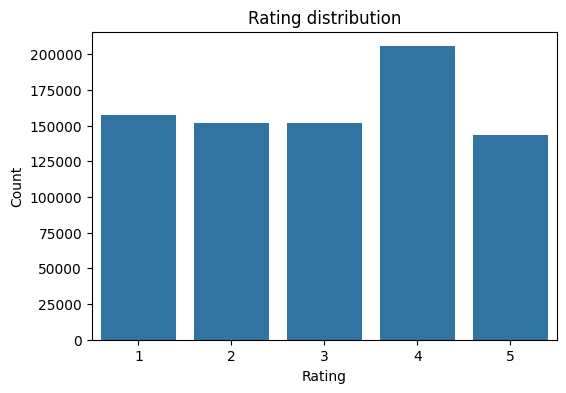

          char_len   word_len
Rating                       
1       174.633461  33.161983
2       219.746593  41.839523
3       202.685443  39.103861
4       211.759396  40.716645
5       179.676403  33.545933


In [30]:
# Basic stats
total_reviews = len(df)
missing_pct = df.isna().mean() * 100
rating_counts = df['Rating'].value_counts().sort_index()

print('Total reviews:', total_reviews)
print('Missing percent per column:\n', missing_pct)
print('Rating counts:\n', rating_counts)

# Plot rating distribution
plt.figure(figsize=(6,4))
sns.barplot(x=rating_counts.index, y=rating_counts.values)
plt.title('Rating distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# # Reviews over time (monthly)
# df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
# by_month = df.set_index('Date').resample('M').size()
# plt.figure(figsize=(12,4))
# by_month.plot()
# plt.title('Reviews per month')
# plt.show()

# Average review length by rating
# compute char and word counts
char_len = df['Review_Text'].astype(str).str.len()
word_len = df['Review_Text'].astype(str).str.split().apply(lambda x: len(x) if isinstance(x, list) else 0)
summary_len = df.assign(char_len=char_len, word_len=word_len).groupby('Rating')[['char_len','word_len']].mean()
print(summary_len)

## 5) Rating-wise textual analysis

### Generate word frequency distribution for each rating

In [31]:
# ============================
# Basic Cleaning Helper
# ============================

# Load English stopwords
stop_words = set(stopwords.words('english'))

# Regex to remove everything except letters, numbers and spaces
RE_KEEP = re.compile(r"[^a-zA-Z0-9\s]")

# Cleaning function for text
def clean_text(s):
    # Handle missing values
    if pd.isna(s):
       return ''

    # Convert to lowercase
    s = str(s).lower()

    # Remove special characters and punctuation
    s = RE_KEEP.sub(' ', s)

    # Remove extra spaces
    s = re.sub('\s+', ' ', s).strip()
    return s


# ============================
# Sampling Data Per Rating
# ============================

# Maximum number of samples to take per rating label (to balance dataset)
sample_per_rating = 50000

frames = []

for r in sorted(df['Rating'].unique()):
    # Filter rows with the specific rating
    sub = df[df['Rating'] == r]

    # Downsample if the rating has more rows than allowed
    if len(sub) > sample_per_rating:
        sub = sub.sample(sample_per_rating, random_state=42)

    # Copy the dataframe to avoid warnings
    sub = sub.copy()

    # Apply text cleaning to Review_Text
    sub['cleaned'] = sub['Review_Text'].astype(str).apply(clean_text)

    # Append processed subset
    frames.append(sub)

# Combine all ratings back into one balanced dataset
sampled = pd.concat(frames)


# ============================
# Tokenizing and Counting Words per Rating
# ============================

from collections import defaultdict

# Dictionary where key = rating and value = word Counter
rating_counts_words = defaultdict(Counter)

# Group the sampled data by rating category
for rating, group in sampled.groupby('Rating'):

    # Loop through each cleaned review text
    for doc in group['cleaned_review']:

        # Tokenize into words, remove stopwords and single-character tokens
        tokens = [
            w for w in word_tokenize(doc)
            if w not in stop_words and len(w) > 1
        ]

        # Update word frequency counter for this rating
        rating_counts_words[rating].update(tokens)


# ============================
# Extract Top 20 Most Frequent Words per Rating
# ============================

top20_per_rating = {
    r: rating_counts_words[r].most_common(20)
    for r in rating_counts_words
}
top20_per_rating

{1: [('phone', 23734),
  ('case', 16267),
  ('product', 11285),
  ('get', 10267),
  ('buy', 9865),
  ('money', 9769),
  ('work', 9641),
  ('screen', 9128),
  ('one', 8849),
  ('dont', 7958),
  ('use', 7295),
  ('waste', 7252),
  ('would', 7147),
  ('charge', 6945),
  ('time', 6077),
  ('break', 5969),
  ('even', 5901),
  ('day', 5376),
  ('return', 5236),
  ('doesnt', 5076)],
 2: [('case', 30961),
  ('phone', 29007),
  ('get', 12039),
  ('use', 12033),
  ('one', 10587),
  ('look', 9896),
  ('screen', 9795),
  ('work', 9676),
  ('would', 8881),
  ('like', 8768),
  ('good', 8130),
  ('month', 7641),
  ('charge', 7626),
  ('break', 6861),
  ('well', 6808),
  ('fit', 6661),
  ('buy', 6323),
  ('make', 6210),
  ('product', 6205),
  ('time', 6093)],
 3: [('case', 31334),
  ('phone', 26689),
  ('get', 12539),
  ('good', 11420),
  ('use', 10333),
  ('like', 10332),
  ('work', 10001),
  ('screen', 8917),
  ('one', 8444),
  ('look', 8366),
  ('well', 7981),
  ('fit', 7768),
  ('would', 7238),
  


### Word clouds 

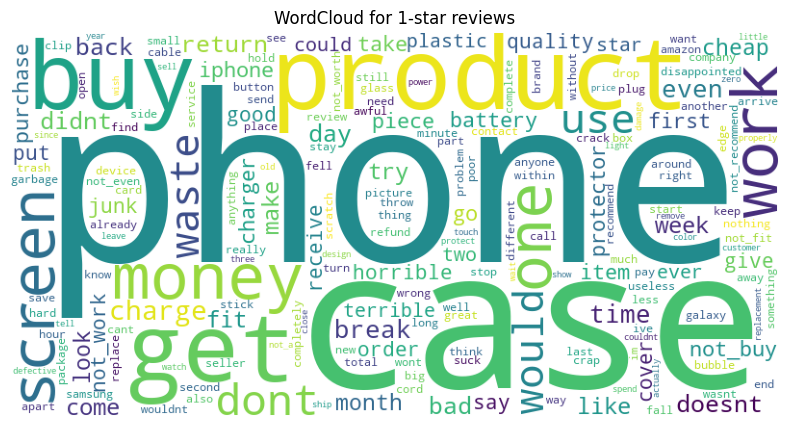

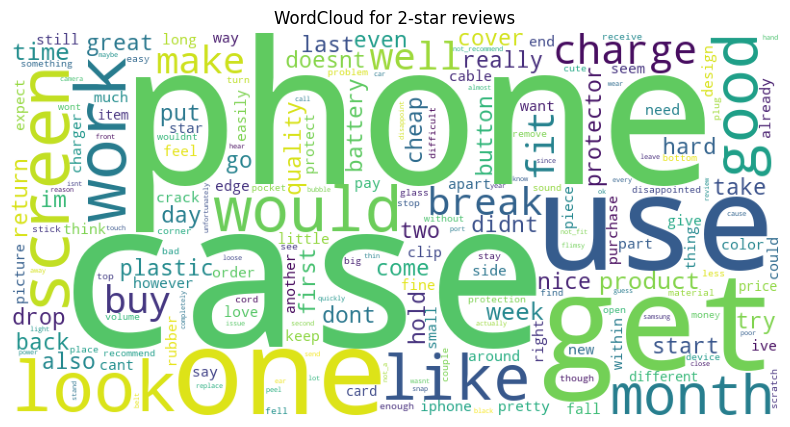

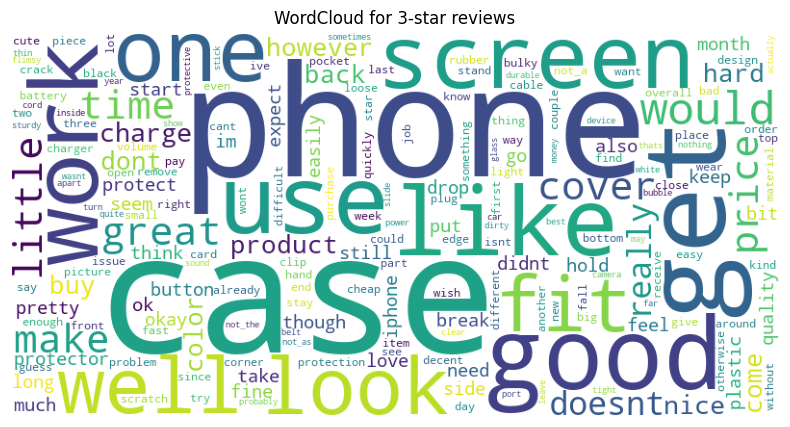

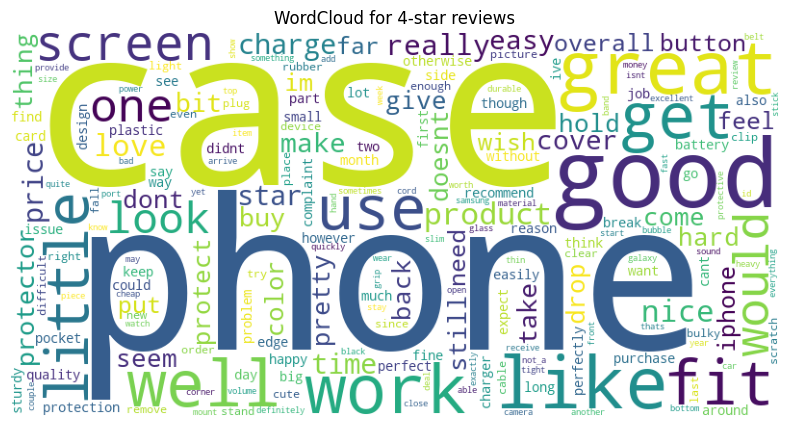

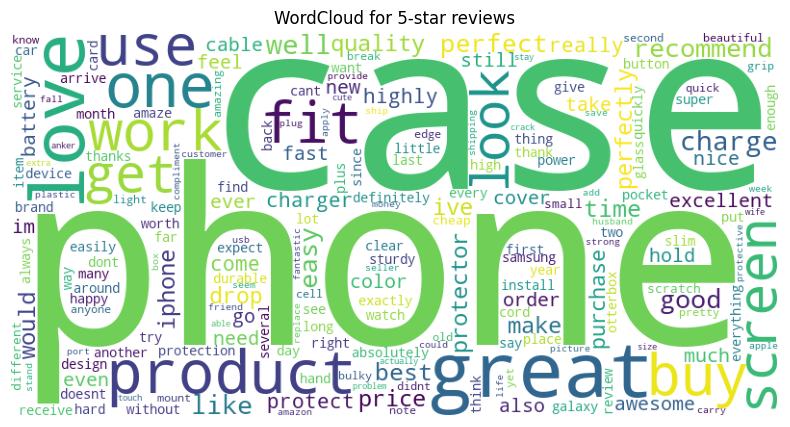

In [31]:
wc = WordCloud(width=800, height=400, background_color='white')
for r in [1,2,3,4,5]:
    freqs = dict(rating_counts_words[r])
    plt.figure(figsize=(10,5))
    plt.imshow(wc.generate_from_frequencies(freqs))
    plt.axis('off')
    plt.title(f'WordCloud for {r}-star reviews')
    plt.show()


### Sentiment-heavy words by rating

* Create a list of words with highest average sentiment contribution. One heuristic: compute polarity of sentences containing the token and average.

In [32]:
# Compute TextBlob polarity per review in sampled
sampled['polarity'] = sampled['cleaned'].apply(lambda x: TextBlob(x).sentiment.polarity)

word_sentiments = {}
for r in sorted(sampled['Rating'].unique()):
    df_r = sampled[sampled['Rating']==r]
    word_scores = defaultdict(list)
    for _, row in df_r.iterrows():
        toks = [w for w in word_tokenize(row['cleaned']) if w not in stop_words]
        for t in set(toks):
            word_scores[t].append(row['polarity'])
    # average
    word_sentiments[r] = {w: np.mean(scores) for w, scores in word_scores.items() if len(scores) >= 5}

In [33]:
# Get top positive/negative words per rating
sentiment_words = {
    r: {
        'most_positive': sorted(word_sentiments[r].items(), key=lambda x: -x[1])[:20],
        'most_negative': sorted(word_sentiments[r].items(), key=lambda x: x[1])[:20]
    }
    for r in word_sentiments
}
sentiment_words

{np.int64(1): {'most_positive': [('charity', np.float64(0.3158333333333333)),
   ('wonderfully', np.float64(0.3049052028218695)),
   ('elegant', np.float64(0.2659548611111111)),
   ('wonderful', np.float64(0.2630956567438049)),
   ('excellent', np.float64(0.25716776580907014)),
   ('timing', np.float64(0.2534834656084656)),
   ('gorgeous', np.float64(0.24067176870748302)),
   ('hassles', np.float64(0.23557766743060862)),
   ('japan', np.float64(0.225548668503214)),
   ('defeated', np.float64(0.22242307692307692)),
   ('slanted', np.float64(0.2212380952380953)),
   ('pleather', np.float64(0.2165)),
   ('handy', np.float64(0.21575689720332578)),
   ('canceling', np.float64(0.20985454545454546)),
   ('frequencies', np.float64(0.20114117364117365)),
   ('disgraceful', np.float64(0.200687074829932)),
   ('restore', np.float64(0.19955597643097645)),
   ('greatest', np.float64(0.19749203342953345)),
   ('flicker', np.float64(0.19603937728937731)),
   ('perfect', np.float64(0.19192744258465821

 shows per-rating positive/negative tokens , useful to see what users praise/complain about.

## 6) Product-wise rating distribution

In [34]:
# Top 10 products by review count
top_products = df['Product_Name'].value_counts().head(10)

# For each top product, rating distribution
top10 = top_products.index.tolist()
prod_rating_dist = df[df['Product_Name'].isin(top10)].groupby(['Product_Name','Rating']).size().unstack(fill_value=0)
prod_rating_dist_pct = prod_rating_dist.div(prod_rating_dist.sum(axis=1), axis=0)

# Which products get 5-star most frequently (percentage)
product_5star_pct = df.groupby('Product_Name').apply(lambda x: (x['Rating']==5).mean())
product_1star_pct = df.groupby('Product_Name').apply(lambda x: (x['Rating']==1).mean())

# Filter to products with at least N reviews to avoid tiny-sample noise
min_reviews = 100
product_5star_pct = product_5star_pct[df.groupby('Product_Name').size() >= min_reviews].sort_values(ascending=False).head(20)
product_1star_pct = product_1star_pct[df.groupby('Product_Name').size() >= min_reviews].sort_values(ascending=False).head(20)


C:\Users\kjnav\AppData\Local\Temp\ipykernel_10856\2145687870.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_5star_pct = df.groupby('Product_Name').apply(lambda x: (x['Rating']==5).mean())
C:\Users\kjnav\AppData\Local\Temp\ipykernel_10856\2145687870.py:11: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  product_1star_pct = df.groupby('Product_Name').apply(lambda x: (x['Rating']==1).mean())


In [35]:
product_5star_pct

Product_Name
Anker 40W 5-Port USB Wall Charger, PowerPort 5 for iPhone Xs/XS Max/XR/X/8/7/6/Plus, iPad Pro/Air 2/Mini, Galaxy S9/S8/Edge/Plus, Note 8/7, LG, Nexus, HTC and More                                     0.700483
Anker Quick Charge 3.0 42W Dual USB Car Charger, PowerDrive+ 2 for Galaxy S7/S6/Edge/Plus, Note 5/4 and PowerIQ for iPhone XS/XS Max/XR/X/8/7/6/Plus, iPad Pro/Air 2/mini, LG, Nexus, HTC and More      0.685714
Anker 60W 6 Port USB Wall Charger, PowerPort 6 for iPhone Xs/XS Max/XR/X/8/7/6/Plus, iPad Pro/Air 2/Mini/iPod, Galaxy S9/S8/S7/S6/Edge/Plus, Note 8/7, LG, Nexus, HTC and More                          0.648829
USB Type C Cable, Anker Powerline+ USB C to USB 3.0 Cable (3ft), High Durability, for Samsung Galaxy Note 8, S8, S8+, S9, iPad Pro 2018, MacBook, Sony XZ, LG V20 G5 G6, HTC 10, Xiaomi 5 and More      0.642276
RAMPOW Micro USB Cable Android, [6.5ft] Sync and Fast Charging, Nylon Braided Samsung USB Cable - Android USB Cable Compatible Moto, BLU, Samsung Galax

In [38]:
product_1star_pct

Product_Name
Galaxy S4 Case - S IV Case - Infinite Love Teal Glitter Anchor Samsung Galaxy i9500 Case Snap On Case (multi)                                                                     0.782123
Inovat 3X USB Lightning Cable Data Sync Charger Cord for Apple iPhone 7,iPhone 8,8 Plus,iPhone X,SE,6s Plus, 6s, 6 Plus, 6, 5s, 5c, 5, iPad Air, iPad Mini, iPod Touch (White)    0.745283
OtterBox Alpha Glass Series Screen Protector for Samsung Galaxy S8 - Retail Packaging - Clear                                                                                     0.724409
Chromo Inc 2600mAh Lipstick Power Bank External Battery Charger in Hot Pink                                                                                                       0.682119
ACEFAST INC Floral Paisley Flower Plastic Case, White                                                                                                                             0.663551
Anchor Chevron Retro Vintage Tribal Nebula Pattern H

**Interpretation steps to include:**

* Show top 10 products by review count and their rating breakdowns.
* Flag products with high proportions of 1-star reviews — candidate for quality issues.
* Flag products with very high 5-star proportion but low review counts — suspect fake reviews.

## 7) Text statistics by rating

In [36]:
# Precompute columns
df['char_len'] = df['Review_Text'].astype(str).str.len()
df['word_len'] = df['Review_Text'].astype(str).str.split().apply(lambda x: len(x) if isinstance(x, list) else 0)

# Polarity & subjectivity (TextBlob) -- sample for speed
sample_tb = df.sample(100000, random_state=42)
sample_tb['polarity'] = sample_tb['Review_Text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)
sample_tb['subjectivity'] = sample_tb['Review_Text'].astype(str).apply(lambda x: TextBlob(x).sentiment.subjectivity)

text_stats = sample_tb.groupby('Rating')[['char_len','word_len','polarity','subjectivity']].agg(['mean','median','std','count'])
text_stats

char_len                             word_len                    \
              mean median         std  count       mean median        std   
Rating                                                                      
1       174.783227  140.0  124.079497  19412  33.169483   27.0  23.312642   
2       220.045016  191.0  136.647799  18882  41.907690   37.0  25.760386   
3       203.518632  170.0  132.061377  18597  39.228800   33.0  25.139353   
4       210.040177  178.0  130.933583  25363  40.369396   34.0  24.972347   
5       179.181393  143.0  127.359278  17746  33.471937   27.0  24.100258   

               polarity                            subjectivity            \
        count      mean    median       std  count         mean    median   
Rating                                                                      
1       19412 -0.105744 -0.045000  0.311971  19412     0.454502  0.466667   
2       18882  0.087877  0.078522  0.228819  18882     0.498211  0.504762   
3       18597  0.169812  0.162500  0.225549  18597     0.523673  0.525000   
4       25363  0.252871  0.235714  0.217132  25363     0.570181  0.575000   
5       17746  0.423606  0.406667  0.253164  17746     0.595953  0.600000   

                         
             std  count  
Rating                   
1       0.269021  19412  
2       0.208841  18882  
3       0.194900  18597  
4       0.179351  25363  
5       0.192287  17746

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\kjnav\AppData\Roaming\nltk_data...


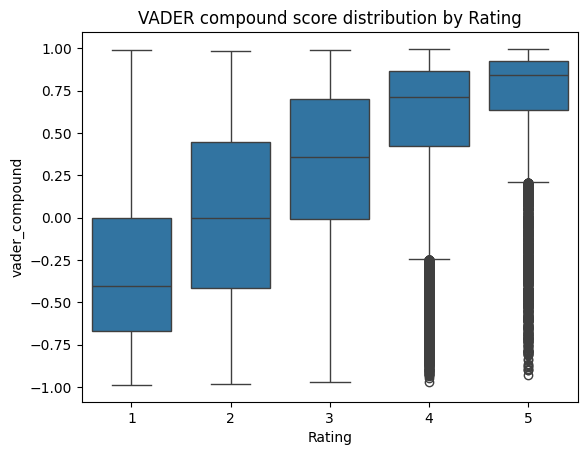

In [41]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()


# Sentiment intensity (VADER) for social-media like intensity
sid = SentimentIntensityAnalyzer()
sample_tb['vader_compound'] = sample_tb['Review_Text'].astype(str).apply(lambda x: sid.polarity_scores(x)['compound'])

sns.boxplot(data=sample_tb, x='Rating', y='vader_compound')
plt.title('VADER compound score distribution by Rating')
plt.show()

**Interpretation:**

* Compare polarity/subjectivity and VADER intensity across ratings.
* Check if neutral/ambiguous reviews exist (polarity near 0) and how they map to numeric ratings.

## 8) Advanced NLP Insights

### 8.1 N-grams analysis (bigrams, trigrams) per rating

In [43]:
from collections import Counter

def top_ngrams(texts, ngram=2, topn=30):
    c = Counter()
    for t in texts:
        toks = [w for w in word_tokenize(clean_text(t)) if w not in stop_words]
        for ng in ngrams(toks, ngram):
            c[' '.join(ng)] += 1
    return c.most_common(topn)

bigrams_per_rating = {r: top_ngrams(df[df['Rating']==r]['Review_Text'].astype(str).sample(20000, random_state=42), ngram=2) for r in range(1,6)}
trigrams_per_rating = {r: top_ngrams(df[df['Rating']==r]['Review_Text'].astype(str).sample(20000, random_state=42), ngram=3) for r in range(1,6)}


In [44]:
bigrams_per_rating

{1: [('waste money', 2162),
  ('screen protector', 820),
  ('fit phone', 623),
  ('phone case', 525),
  ('stopped working', 503),
  ('waste time', 440),
  ('piece junk', 382),
  ('would recommend', 351),
  ('even fit', 307),
  ('first time', 300),
  ('money back', 299),
  ('never buy', 283),
  ('time money', 283),
  ('charge phone', 281),
  ('one star', 277),
  ('poor quality', 271),
  ('buy product', 266),
  ('piece crap', 253),
  ('put phone', 247),
  ('cheaply made', 236),
  ('iphone 6', 234),
  ('save money', 229),
  ('fell apart', 215),
  ('looks like', 209),
  ('dropped phone', 207),
  ('screen protectors', 205),
  ('get pay', 205),
  ('2 weeks', 202),
  ('case fit', 200),
  ('customer service', 197)],
 2: [('screen protector', 1013),
  ('phone case', 722),
  ('would recommend', 535),
  ('get pay', 430),
  ('two stars', 376),
  ('2 weeks', 351),
  ('fit phone', 341),
  ('protect phone', 336),
  ('stopped working', 309),
  ('2 stars', 298),
  ('charge phone', 294),
  ('dropped pho

In [45]:
trigrams_per_rating

{1: [('waste time money', 213),
  ('total waste money', 135),
  ('complete waste money', 133),
  ('even fit phone', 128),
  ('want money back', 104),
  ('worst case ever', 97),
  ('get money back', 89),
  ('give zero stars', 85),
  ('phone waste money', 82),
  ('waste money time', 81),
  ('would recommend product', 80),
  ('nothing like picture', 79),
  ('iphone 6 plus', 74),
  ('dont waste money', 74),
  ('would recommend anyone', 71),
  ('looks nothing like', 66),
  ('worst phone ever', 65),
  ('give 0 stars', 63),
  ('broke first day', 62),
  ('case fit phone', 61),
  ('buy waste money', 59),
  ('work waste money', 57),
  ('broke first time', 55),
  ('wish could give', 53),
  ('worst screen protector', 53),
  ('worst product ever', 52),
  ('waste money buy', 51),
  ('save money buy', 49),
  ('product waste money', 49),
  ('glass screen protector', 48)],
 2: [('guess get pay', 108),
  ('gave two stars', 91),
  ('gave 2 stars', 81),
  ('would recommend product', 77),
  ('first time dr

### 8.2 Aspect-based sentiment analysis (rule-based)

* extract noun phrases as aspects and compute sentiment of sentences mentioning them.: 

In [48]:
import spacy
nlp = spacy.load('en_core_web_sm')

# Example function
from collections import defaultdict

def aspect_sentiment_for_docs(docs, top_k_aspects=50):
    aspect_scores = defaultdict(list)
    for doc in nlp.pipe(docs, batch_size=50):
        sents = list(doc.sents)
        for sent in sents:
            # noun chunks as potential aspects
            aspects = [chunk.root.text.lower() for chunk in sent.noun_chunks]
            sent_pol = TextBlob(sent.text).sentiment.polarity
            for a in set(aspects):
                aspect_scores[a].append(sent_pol)
    # aggregate
    agg = sorted([(a, np.mean(scores), len(scores)) for a, scores in aspect_scores.items() if len(scores) >= 5], key=lambda x: -abs(x[1]))
    return agg[:top_k_aspects]

# Run on sample
sample_aspect = df[df['Rating'].isin([1,5])]['Review_Text'].astype(str).sample(20000, random_state=42)
aspects = aspect_sentiment_for_docs(sample_aspect)


In [49]:
aspects

[('terrible', np.float64(-1.0), 8),
 ('awful', np.float64(-0.944047619047619), 28),
 ('awesome', np.float64(0.8773172905525848), 34),
 ('excellent', np.float64(0.844102564102564), 13),
 ('perfect', np.float64(0.8311474867724867), 36),
 ('horrible', np.float64(-0.8262820512820512), 13),
 ('best', np.float64(0.7927128427128427), 11),
 ('enemy', np.float64(-0.7444444444444445), 9),
 ('win', np.float64(0.7083653846153847), 13),
 ('great', np.float64(0.7005699855699856), 7),
 ('magpul', np.float64(0.6849999999999999), 5),
 ('invention', np.float64(0.6428571428571429), 7),
 ('companion', np.float64(0.625), 5),
 ('value', np.float64(0.6200754357298475), 102),
 ('perfectly', np.float64(0.6165535714285715), 10),
 ('stuffer', np.float64(0.6083333333333333), 6),
 ('lock', np.float64(0.5943055555555555), 5),
 ('lol', np.float64(0.5942106782106783), 30),
 ('incredible', np.float64(0.5833333333333334), 6),
 ('g5', np.float64(0.5777777777777777), 6),
 ('stylish', np.float64(0.563860544217687), 7),
 (

**Interpretation:** aspects with strongly negative averages indicate product attributes to fix (delivery, battery, size, packaging).

### 8.3 Named Entity Recognition (NER)

In [50]:
# Use spaCy's NER; for product-specific entities consider fine-tuned NER or custom gazetteer
ents = Counter()
for doc in nlp.pipe(df['Review_Text'].astype(str).sample(50000, random_state=42), batch_size=50):
    for e in doc.ents:
        ents[(e.label_, e.text.lower())] += 1

# Top entities by label
from itertools import groupby
ents_most = ents.most_common(200)

In [51]:
ents_most

[(('CARDINAL', 'one'), 2418),
 (('ORDINAL', 'first'), 2348),
 (('CARDINAL', 'two'), 1702),
 (('CARDINAL', '2'), 1458),
 (('CARDINAL', '5'), 1220),
 (('CARDINAL', '3'), 1091),
 (('CARDINAL', '4'), 1078),
 (('ORDINAL', 'second'), 819),
 (('ORG', 'amazon'), 546),
 (('CARDINAL', 'three'), 511),
 (('CARDINAL', '1'), 493),
 (('ORG', 'iphone'), 485),
 (('ORG', 'usb'), 468),
 (('DATE', 'a week'), 457),
 (('ORG', 'samsung'), 454),
 (('CARDINAL', '6'), 442),
 (('DATE', 'today'), 341),
 (('ORG', 'otterbox'), 318),
 (('ORG', 'apple'), 297),
 (('DATE', 'a month'), 293),
 (('CARDINAL', 'half'), 279),
 (('ORG', 'ipad'), 267),
 (('DATE', 'a few months'), 258),
 (('CARDINAL', 'four'), 242),
 (('CARDINAL', 'five'), 226),
 (('DATE', '2 weeks'), 223),
 (('DATE', 'a few days'), 205),
 (('DATE', 'a few weeks'), 204),
 (('PERCENT', '100%'), 197),
 (('CARDINAL', '4s'), 194),
 (('CARDINAL', 'zero'), 190),
 (('ORG', 'spigen'), 181),
 (('DATE', '2 days'), 177),
 (('ORG', 'buy'), 175),
 (('DATE', 'about a month')

### 8.4 Topic modeling per rating (LDA)

In [52]:
# Preprocess
from gensim.utils import simple_preprocess

def preprocess_for_lda(texts):
    return [ [w for w in simple_preprocess(t) if w not in stop_words and len(w)>2] for t in texts]

lda_results = {}
for r in range(1,6):
    texts = df[df['Rating']==r]['Review_Text'].astype(str).sample(20000, random_state=42).tolist()
    tokenized = preprocess_for_lda(texts)
    dictionary = corpora.Dictionary(tokenized)
    corpus = [dictionary.doc2bow(t) for t in tokenized]
    lda = gensim.models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6, passes=5, random_state=42)
    lda_results[r] = lda.print_topics()

# Print topics per rating
for r, topics in lda_results.items():
    print('Rating', r)
    for t in topics:
        print(t)


Rating 1
(0, '0.021*"product" + 0.021*"one" + 0.017*"return" + 0.016*"amazon" + 0.014*"item" + 0.013*"received" + 0.012*"seller" + 0.012*"star" + 0.011*"refund" + 0.010*"work"')
(1, '0.053*"phone" + 0.027*"work" + 0.025*"money" + 0.023*"charge" + 0.019*"waste" + 0.016*"buy" + 0.016*"battery" + 0.015*"charger" + 0.015*"would" + 0.013*"time"')
(2, '0.079*"screen" + 0.037*"phone" + 0.024*"protector" + 0.013*"glass" + 0.012*"cracked" + 0.012*"dropped" + 0.009*"stick" + 0.009*"one" + 0.009*"buy" + 0.007*"put"')
(3, '0.042*"fit" + 0.024*"phone" + 0.016*"galaxy" + 0.016*"iphone" + 0.015*"work" + 0.014*"samsung" + 0.013*"product" + 0.011*"even" + 0.011*"cable" + 0.007*"note"')
(4, '0.037*"broke" + 0.024*"product" + 0.020*"days" + 0.019*"buy" + 0.019*"one" + 0.019*"week" + 0.018*"first" + 0.017*"money" + 0.016*"broken" + 0.016*"within"')
(5, '0.080*"case" + 0.036*"phone" + 0.020*"like" + 0.016*"money" + 0.016*"cheap" + 0.015*"even" + 0.014*"fit" + 0.012*"buy" + 0.012*"back" + 0.012*"would"')
Ra

## 9) Visualization requirements & modeling diagnostics

* **Distribution plots:** rating counts, review lengths, polarity distributions (code earlier)
* **Heatmaps:** rating vs product category (if product categories exist). Example:

<Axes: xlabel='Rating', ylabel='Product_Name'>

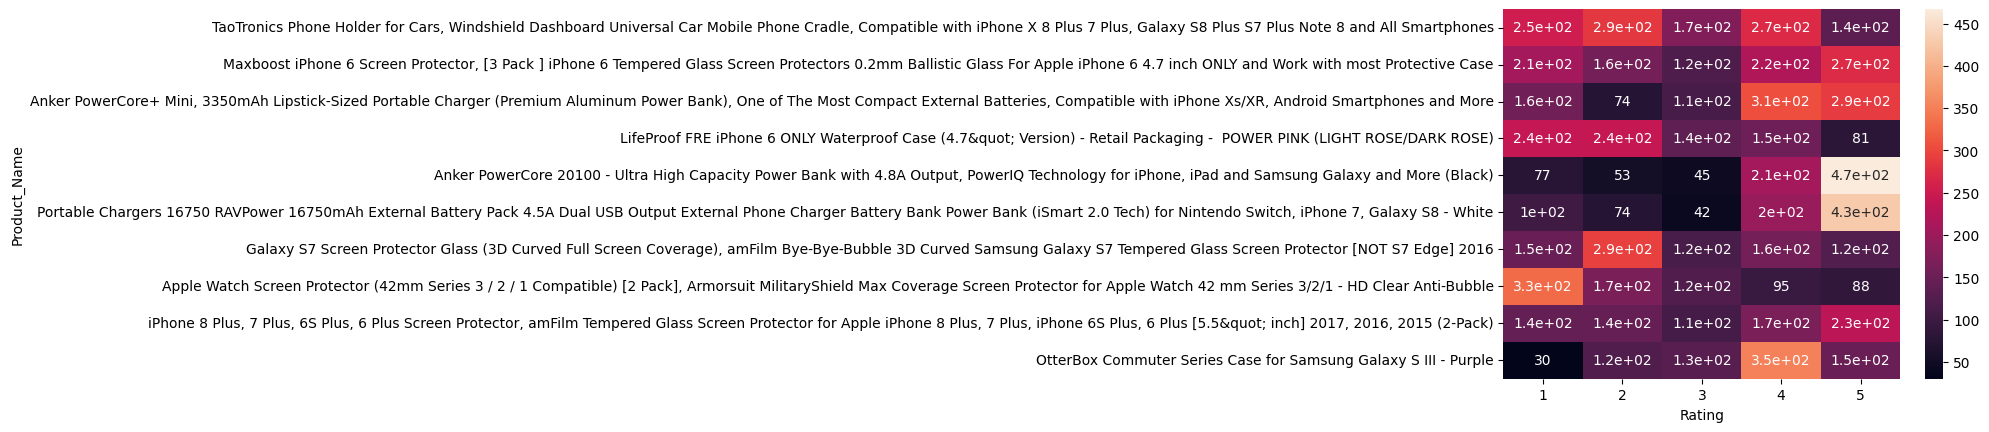

In [ ]:
# # Suppose df has Product_Category column
# pivot = df.pivot_table(index='Product_Name', columns='Rating', aggfunc='size', fill_value=0)
# sns.heatmap(pivot.loc[top10], annot=True)

### 1️ Rating and Text Distribution

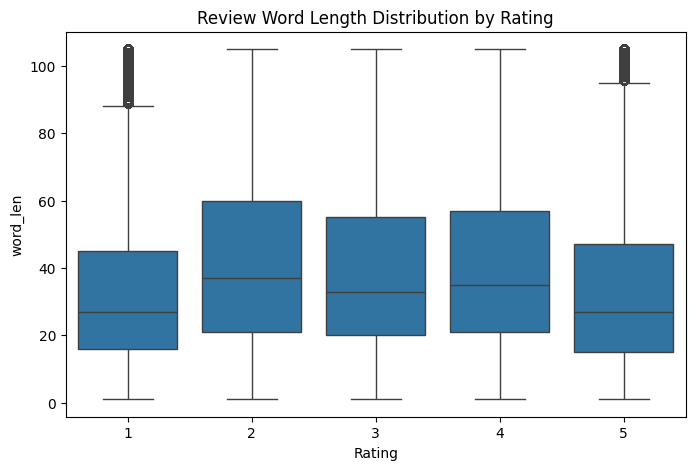

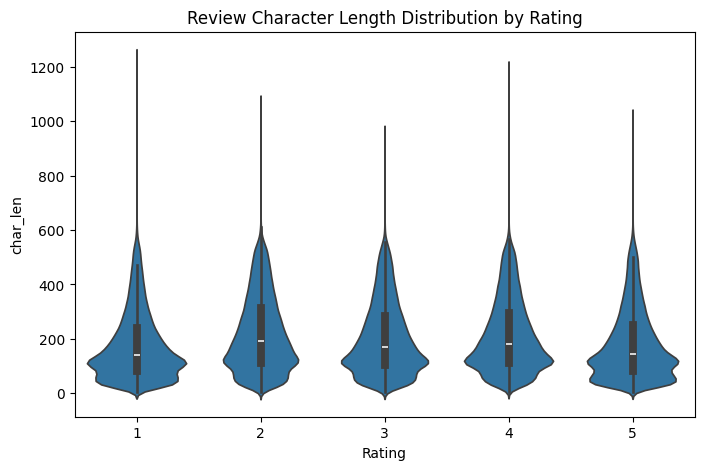

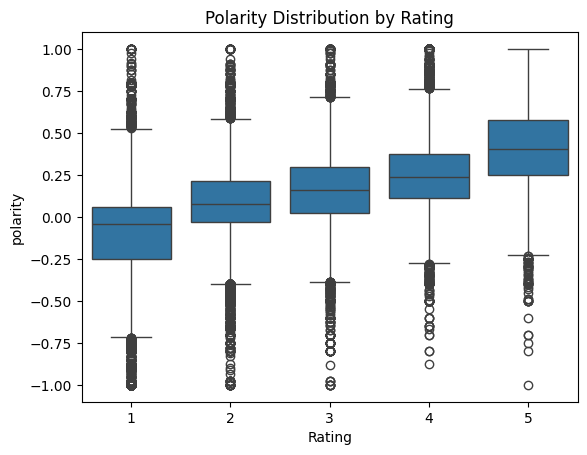

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns


# Boxplot of review length by rating
plt.figure(figsize=(8,5))  # Create figure
sns.boxplot(x='Rating', y='word_len', data=df)  # Draw boxplot
plt.title('Review Word Length Distribution by Rating')
plt.show()


# Violin plot for characters
plt.figure(figsize=(8,5))
sns.violinplot(x='Rating', y='char_len', data=df)
plt.title('Review Character Length Distribution by Rating')
plt.show()


# Sentiment distribution per rating (TextBlob polarity)
sns.boxplot(x='Rating', y='polarity', data=sample_tb)
plt.title('Polarity Distribution by Rating')
plt.show()


### 2️ Temporal Trends 

C:\Users\kjnav\AppData\Local\Temp\ipykernel_16128\2893027962.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  by_month = df.set_index('Date').resample('M').size()


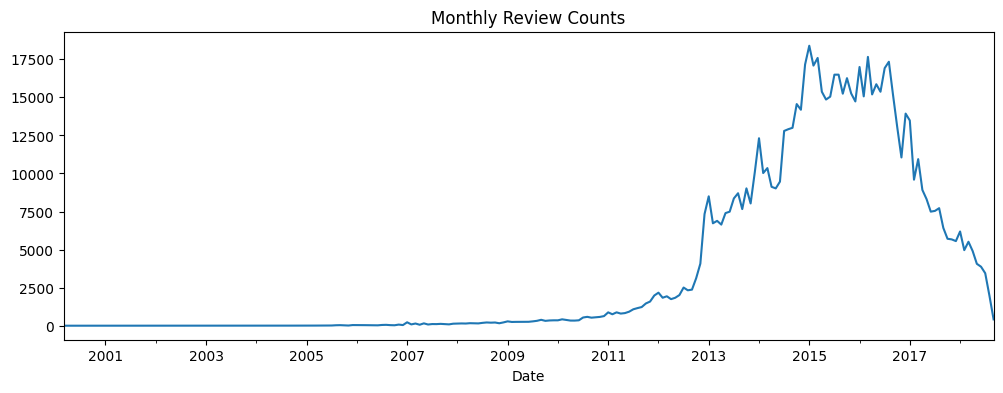

C:\Users\kjnav\AppData\Local\Temp\ipykernel_16128\2893027962.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  avg_rating_month = df.set_index('Date').resample('M')['Rating'].mean()


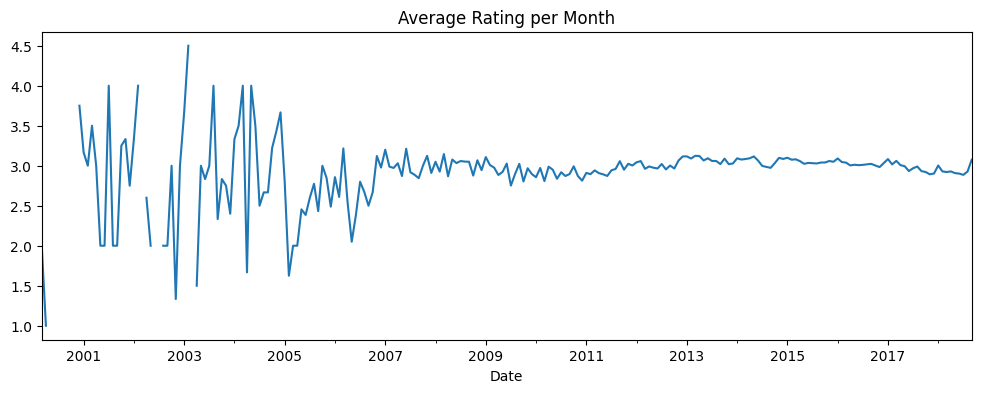

In [55]:
# Reviews per month
by_month = df.set_index('Date').resample('M').size()
plt.figure(figsize=(12,4))
by_month.plot()
plt.title('Monthly Review Counts')
plt.show()

# Average rating over time
avg_rating_month = df.set_index('Date').resample('M')['Rating'].mean()
plt.figure(figsize=(12,4))
avg_rating_month.plot()
plt.title('Average Rating per Month')
plt.show()

### 3️ Verified vs Non-Verified Purchases

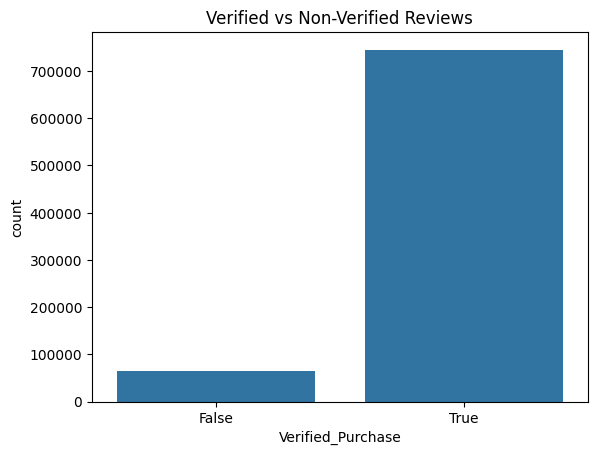

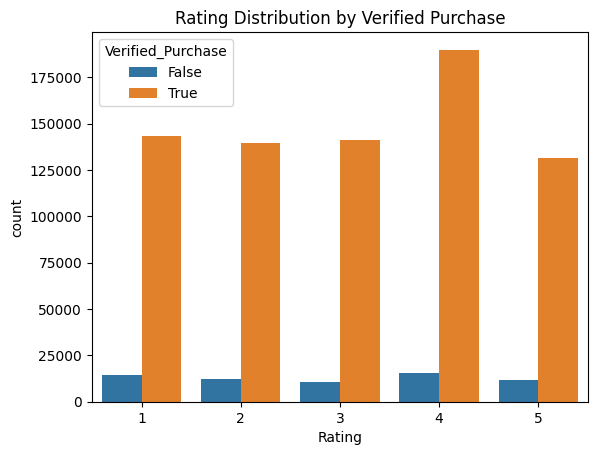

In [56]:
# Bar chart of Verified vs Non-Verified
sns.countplot(x='Verified_Purchase', data=df)
plt.title('Verified vs Non-Verified Reviews')
plt.show()

# Rating distribution by Verified_Purchase
sns.countplot(x='Rating', hue='Verified_Purchase', data=df)
plt.title('Rating Distribution by Verified Purchase')
plt.show()

### 4️ Product-Level Visualizations

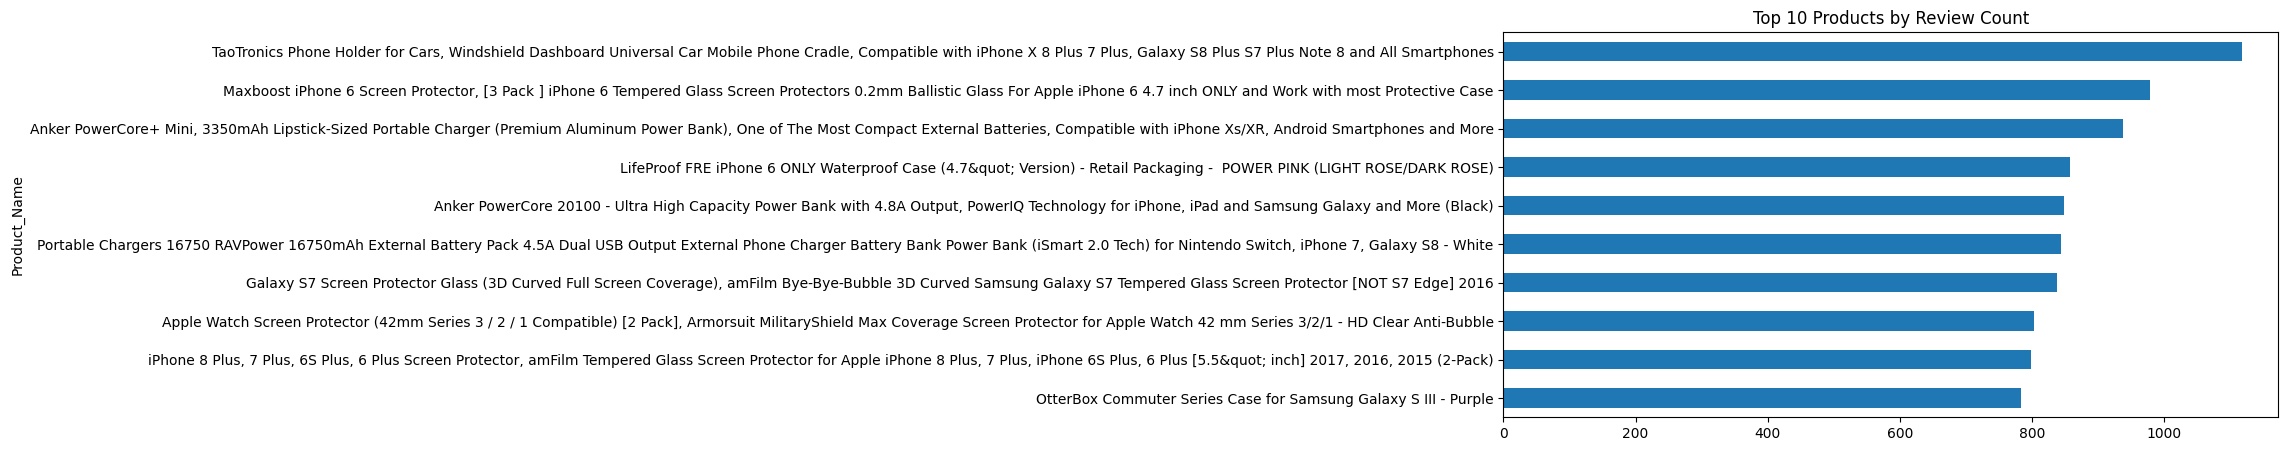

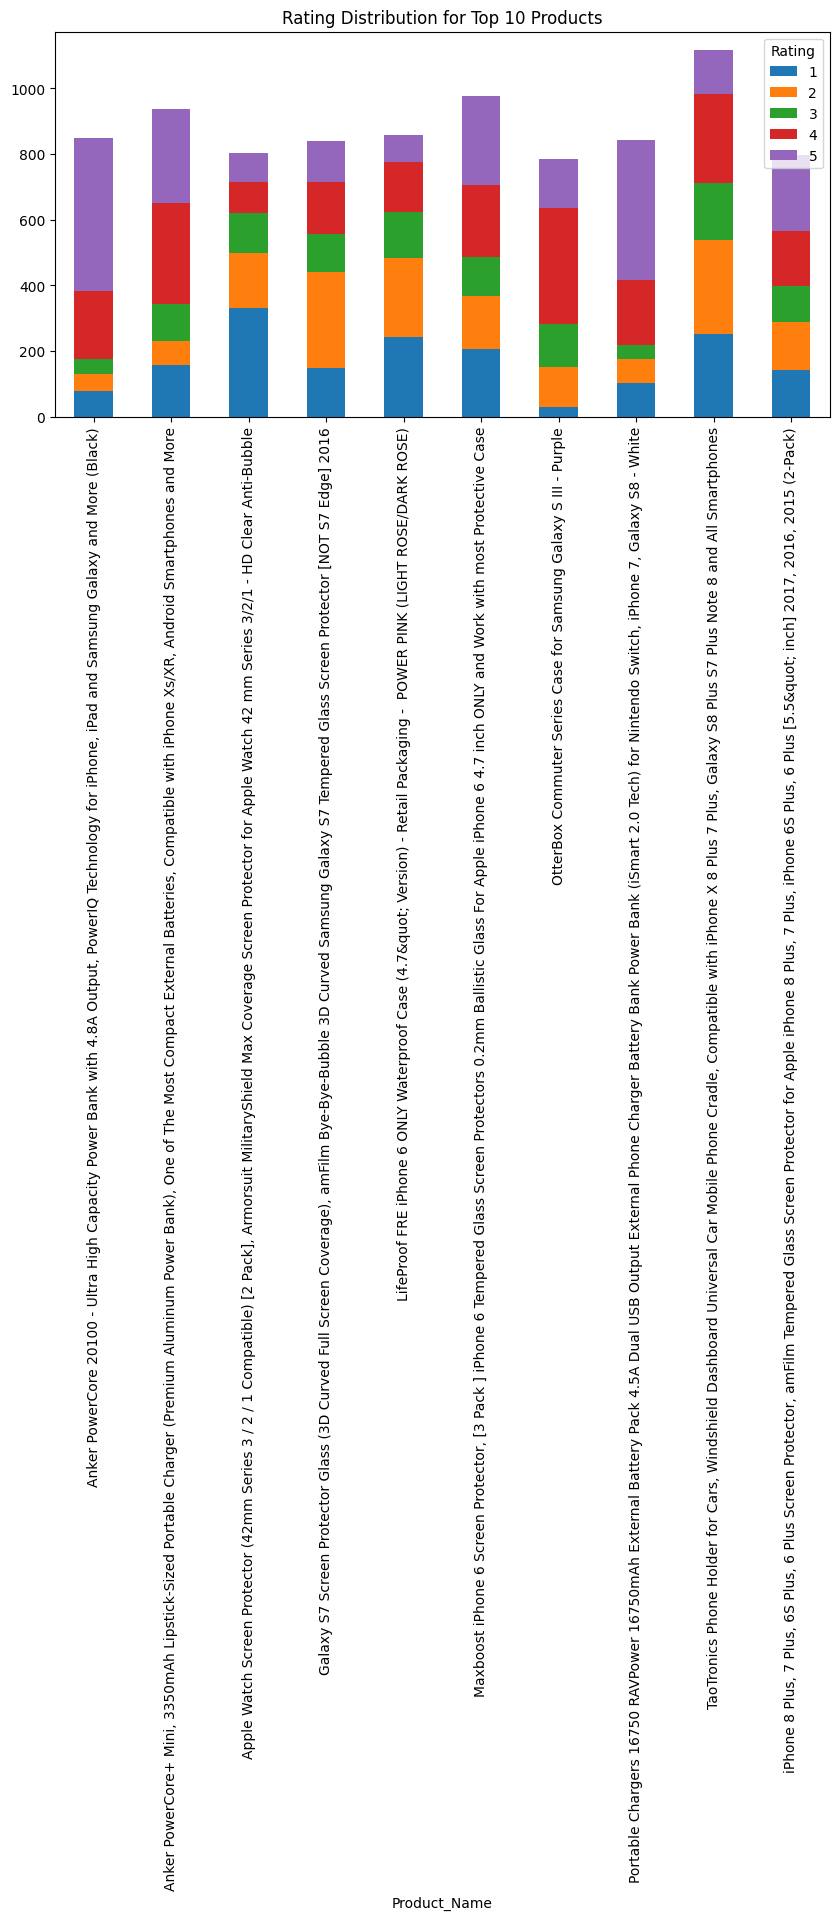

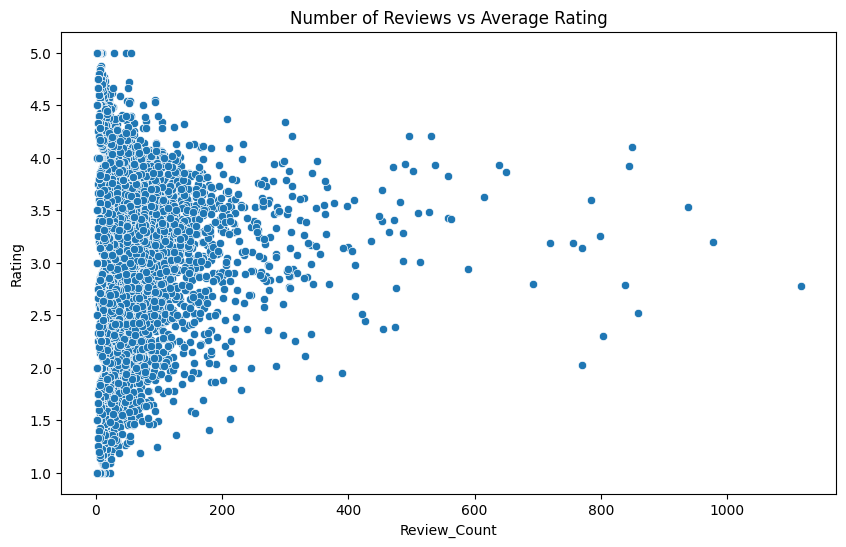

In [57]:
# Top 10 products by review count
top_products = df['Product_Name'].value_counts().head(10)
plt.figure(figsize=(10,5))
top_products.plot(kind='barh')
plt.title('Top 10 Products by Review Count')
plt.gca().invert_yaxis()
plt.show()

# Stacked bar chart: rating distribution per top product
top10 = top_products.index.tolist()
prod_rating_dist = df[df['Product_Name'].isin(top10)].groupby(['Product_Name','Rating']).size().unstack(fill_value=0)
prod_rating_dist.plot(kind='bar', stacked=True, figsize=(10,5))
plt.title('Rating Distribution for Top 10 Products')
plt.show()

# Scatter plot: number of reviews vs average rating
product_stats = df.groupby('Product_Name').agg({'Rating':'mean', 'Review_Text':'count'}).rename(columns={'Review_Text':'Review_Count'})
plt.figure(figsize=(10,6))
sns.scatterplot(x='Review_Count', y='Rating', data=product_stats)
plt.title('Number of Reviews vs Average Rating')
plt.show()

### 6️ Sentiment & Polarity

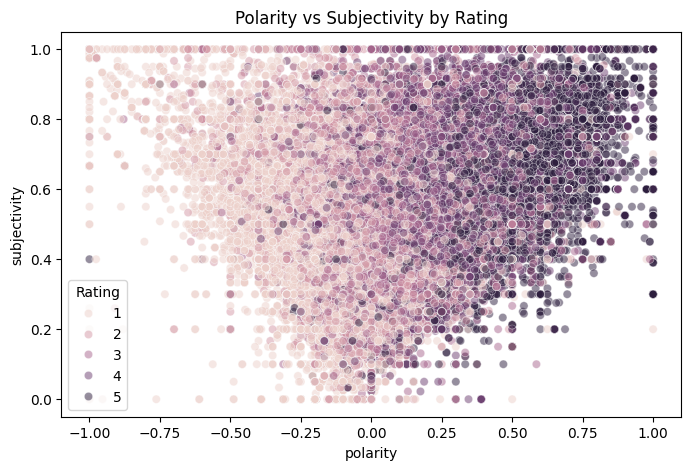

In [59]:
# Scatter plot: polarity vs subjectivity
plt.figure(figsize=(8,5))
sns.scatterplot(x='polarity', y='subjectivity', hue='Rating', data=sample_tb, alpha=0.5)
plt.title('Polarity vs Subjectivity by Rating')
plt.show()

### 7️ Aspect / Feature Insights

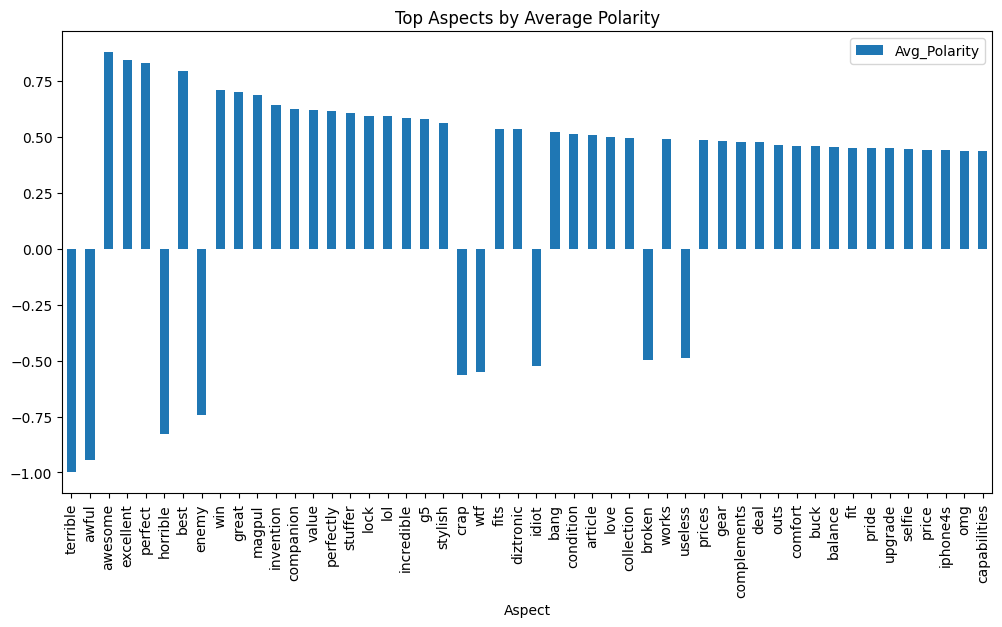

In [ ]:
# Bar chart of top aspects (example from aspect_sentiment_for_docs)
top_aspects = pd.DataFrame(aspects, columns=['Aspect','Avg_Polarity','Count'])
top_aspects.plot.bar(x='Aspect', y='Avg_Polarity', figsize=(12,6))
plt.title('Top Aspects by Average Polarity')
plt.show()

### 8️ NER / Entity Insights 


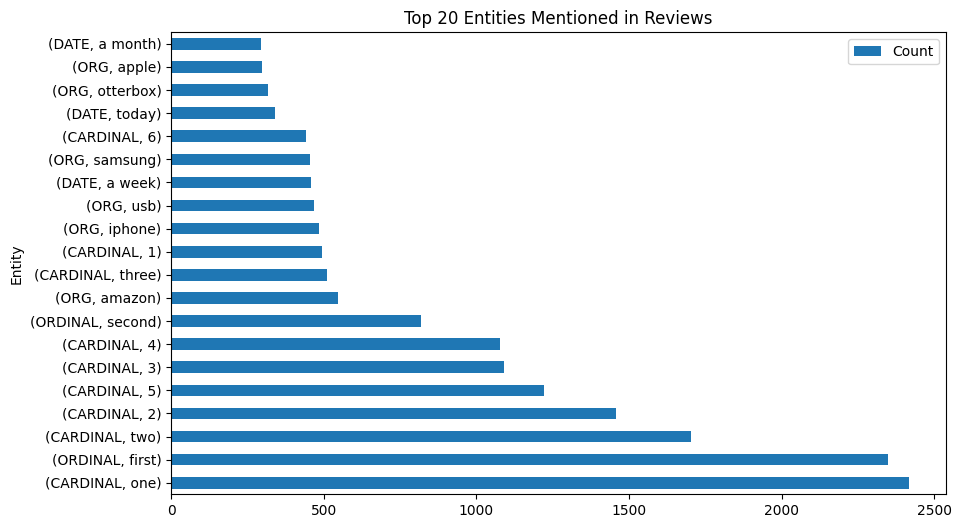

In [ ]:
# # Top 20 entities
# from collections import Counter
# ents_df = pd.DataFrame(ents_most, columns=['Entity','Count'])
# ents_df.head(20).plot.barh(x='Entity', y='Count', figsize=(10,6))
# plt.title('Top 20 Entities Mentioned in Reviews')
# plt.show()

### 9️ Review Length vs Rating

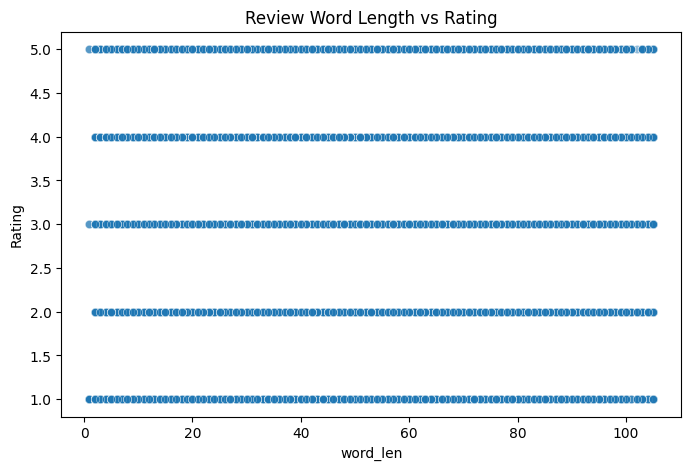

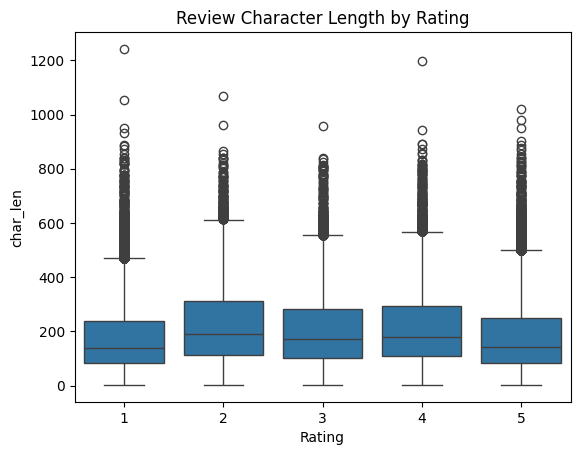

In [62]:

plt.figure(figsize=(8,5))
sns.scatterplot(x='word_len', y='Rating', data=df.sample(20000, random_state=42), alpha=0.5)
plt.title('Review Word Length vs Rating')
plt.show()

sns.boxplot(x='Rating', y='char_len', data=df)
plt.title('Review Character Length by Rating')
plt.show()

<!-- * Provide an executable Jupyter notebook which contains the code, figures, and markdown explanations.
* Export to PDF or HTML for sharing (`jupyter nbconvert --to html notebook.ipynb`).
* Save key aggregated CSVs: top20_per_rating, product_5star_pct, aspect summaries.
Example saves:

pd.DataFrame(top20_per_rating).to_csv('top20_per_rating.csv')
product_5star_pct.to_csv('product_5star_pct.csv') -->


## 11) Business Recommendations & Actionable Insights

### 1️ Actionable Alerts

C:\Users\kjnav\AppData\Local\Temp\ipykernel_16128\1284031051.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



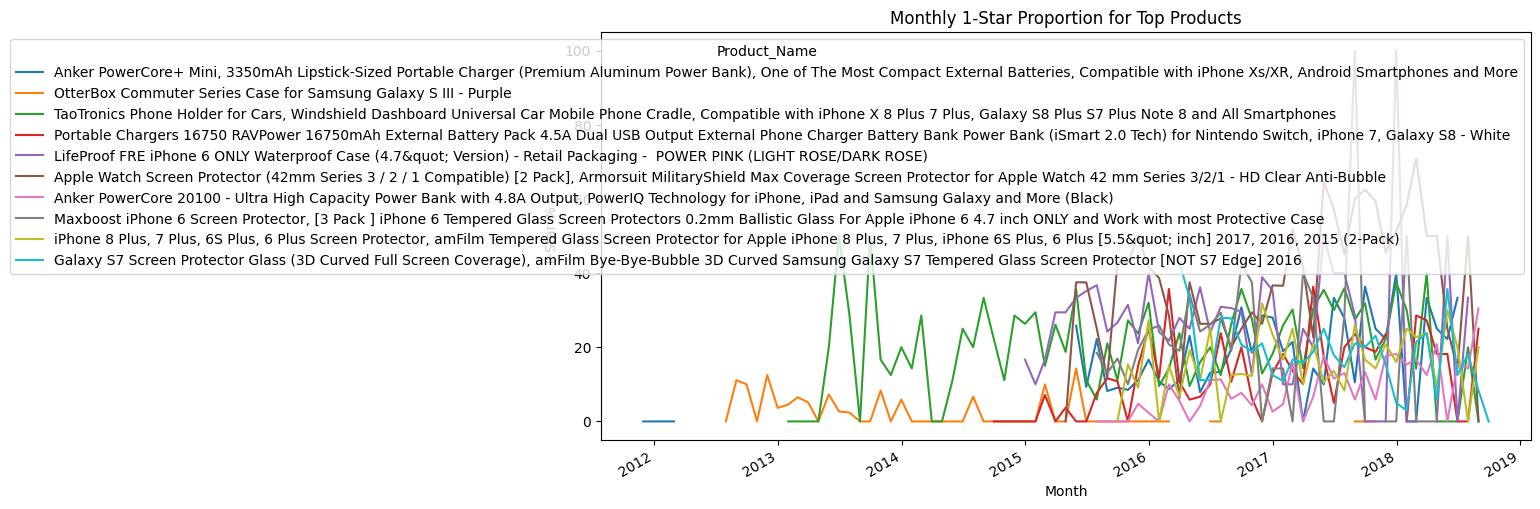

In [69]:
# 1. Aggregate monthly counts per product
monthly_rating = df.set_index('Date').groupby(
    [pd.Grouper(freq='M'), 'Product_Name']
)['Rating'].value_counts().unstack(fill_value=0)

# 2. Calculate 1-star %
monthly_rating['1_star_pct'] = monthly_rating[1] / monthly_rating.sum(axis=1) * 100

# 3. Get top 10 products by total reviews
top_products = df['Product_Name'].value_counts().head(10).index.tolist()

# 4. Filter monthly_rating for only top products
top_monthly = monthly_rating.loc[monthly_rating.index.get_level_values('Product_Name').isin(top_products)]

# 5. Unstack product name for plotting
plot_data = top_monthly['1_star_pct'].unstack(level=1)

# 6. Plot
plot_data.plot(figsize=(12,6))
plt.title('Monthly 1-Star Proportion for Top Products')
plt.ylabel('1-Star %')
plt.xlabel('Month')
plt.show()


### 2️ Root-Cause Analysis

In [70]:
# Negative reviews containing 'delivery' or 'packaging'
negative_reviews = df[df['Rating'] <= 2]
keywords = ['delivery', 'packaging']
for kw in keywords:
    subset = negative_reviews[negative_reviews['Review_Text'].str.contains(kw, case=False, na=False)]
    print(f'Keyword: {kw}, Count: {len(subset)}')
    display(subset[['Product_Name','Date','Review_Text']].head(5))

Keyword: delivery, Count: 842


,Product_Name,Date,Review_Text
165,NOKIA OEM BLC-2 BATTERY 3585 3586i 3587i 3588i...,2010-08-16,delivery was great. BATTERY DOESN'T LAST 2 FU...
927,Wireless Phones Xcessories Holster for Motorol...,2009-10-23,This plastic cell phone clip is junk. The cli...
1606,Car Mount Air Vent Phone Holder Cradle by USA ...,2013-01-06,"While great in theory, this product wasn't gre..."
2790,Telcel SIM Card - Mexico,2013-04-04,NO RETURNS ALLOWED BECAUSE YOU ARE NOT GETTING...
2947,"iPhone 6/6s Screen Protector, ZeroLemon Ultra ...",2015-06-05,Arrived broken upon delivery packaging was fin...


Keyword: packaging, Count: 2052


,Product_Name,Date,Review_Text
1271,CLWHJ Repair and Replacement LCD Display &amp;...,2017-08-09,I ordered multiple and all were defective. One...
2459,Nokia BP-4L for E71 E71x E90 Communicator E61i...,2012-08-26,The item stated that it was going to be in ori...
2595,"Solar Charger, Dizaul 5000mAh Portable Solar P...",2017-06-04,It Doesn't produce a charge from the sun and i...
2947,"iPhone 6/6s Screen Protector, ZeroLemon Ultra ...",2015-06-05,Arrived broken upon delivery packaging was fin...
2995,New Waterproof Shockproof Dirtproof Snowproof ...,2014-03-29,received this case today.out of the packaging ...


### 3️ Review Authenticity Signals

In [71]:
# Extremely short 5-star reviews
short_reviews = df[(df['Rating']==5) & (df['word_len'] < 5)]
print('Short 5-star reviews count:', len(short_reviews))

# Repeated phrases / copy-paste detection (simplified)
duplicates = df[df.duplicated('Review_Text', keep=False)]
print('Potential repeated reviews count:', len(duplicates))


Short 5-star reviews count: 4439
Potential repeated reviews count: 0


In [ ]:
#  # Multiple reviews from same user in short window (if user_id available)
# df.groupby('Product_Name').apply(lambda x: x.set_index('Date').resample('D').size().max())

C:\Users\kjnav\AppData\Local\Temp\ipykernel_16128\611215873.py:2: FutureWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Product_Name
 (Green Silm) Mivizu slim fit hard rubber crystal skin case cover for Apple iPhone 3G / 3GS + screen protector for iPhone 3GS case 8gb, 16gb, 32gb                                                                                                1
 (Many Colors Available) Slim fit hard leather case cover for Apple iPhone 3G and iPhone 3GS 8GB, 16GB, 32GB + Screen Protector                                                                                                                   1
 1800mAh Extended Battery for BlackBerry 8300 / 8330 / 8310 / 8320 /8700G / 8700C / 8703E                                                                                                                                                         1
 2n1 Combo Apple iPhone 3G - Black Premium Leather Flip Case with Removable Video Stand Rotating Belt Clip - Bundled with Screen Protector and Retractable USB Data Sync and Charge Cable (Not Compatible with 1st Generation iPhone)             1
 3 PACK App

### 4️ Feature Suggestions (Aspect-Level)

In [74]:
# Use top aspects from aspect-based sentiment analysis
# Identify product attributes with negative polarity to suggest improvements
top_negative_aspects = [a for a in aspects if a[1] < 0]  # Avg polarity < 0
print('Top negative aspects to improve:', top_negative_aspects[:20])


Top negative aspects to improve: [('terrible', np.float64(-1.0), 8), ('awful', np.float64(-0.944047619047619), 28), ('horrible', np.float64(-0.8262820512820512), 13), ('enemy', np.float64(-0.7444444444444445), 9), ('crap', np.float64(-0.5627159465774176), 246), ('wtf', np.float64(-0.55), 8), ('idiot', np.float64(-0.5243055555555555), 6), ('broken', np.float64(-0.49534722222222227), 10), ('useless', np.float64(-0.48888888888888893), 5)]


### 5️ Customer Segmentation

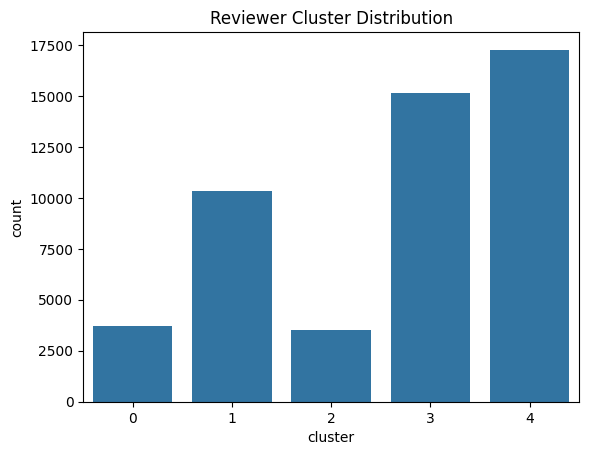

In [75]:
# Example: cluster reviewers by text patterns and sentiment (requires User_ID)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

sample_reviews = df.sample(50000, random_state=42)
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X = tfidf.fit_transform(sample_reviews['Review_Text'].astype(str))
kmeans = KMeans(n_clusters=5, random_state=42).fit(X)
sample_reviews['cluster'] = kmeans.labels_
sns.countplot(x='cluster', data=sample_reviews)
plt.title('Reviewer Cluster Distribution')
plt.show()


### 6️ Churn & Customer Support Integration

In [79]:
from textblob import TextBlob

# Compute polarity for each review
# Polarity: -1 (very negative) to +1 (very positive)
df['polarity'] = df['Review_Text'].astype(str).apply(lambda x: TextBlob(x).sentiment.polarity)

# Urgent negative: Rating <= 2 AND polarity < -0.5
urgent_negative = df[(df['Rating'] <= 2) & (df['polarity'] < -0.5)]

print('Urgent negative reviews count:', len(urgent_negative))




Urgent negative reviews count: 15492


In [80]:
urgent_negative

,Product_Name,Date,Verified_Purchase,Review_Text,Rating,cleaned_review,char_len,word_len,polarity
62,Tracfone 1 Year of Service and 400 Minutes,2016-05-29,False,Lousy experience. Bad value. Horrible customer...,1,lousy experience bad value horrible customer e...,142,20,-0.550
82,"iPhone 6 Plus Waterproof Case, iThrough&trade;...",2015-09-29,True,Terrible product. The touch screen doesnt work...,1,terrible product touch screen doesnt work phon...,102,16,-1.000
147,"Galaxy Note 5 Screen Protector, Jelly Comb Pre...",2016-08-02,True,I received this item damaged and unusable. I a...,1,receive item damage unusable disappointed,66,11,-0.975
153,Garmin Sport PRO Bundle Dog Training Device,2017-05-23,True,Terrible charger and it works intermittently a...,1,terrible charger work intermittently no_lanyar...,88,15,-1.000
174,Original Samsung Galaxy S4 IV LCD Display &amp...,2016-02-23,True,Screen was horrible cracked as soon as i insta...,1,screen horrible crack soon instal display fell...,94,17,-1.000
...,...,...,...,...,...,...,...,...,...
809698,EMPIRE Privacy Screen Protector for Sprint Sam...,2014-10-06,True,Its not a privacy screen at all. I did a test ...,1,not_a privacy screen test see screen still sho...,131,27,-0.750
809768,"iPhone 5S Case, iPhone 5 Case, iPhone SE Case,...",2017-08-05,True,My daughter had been using this case for 7 wee...,2,daughter use case week crack already guess get...,130,25,-0.780
809859,Spring Flower Design Snap On Hard Case for HTC...,2011-03-29,True,This phone cover is very ugly in person. I do...,1,phone cover ugly person dont think even put phone,89,19,-1.000
809878,2X RocketBus USB Sync Charging Charger Cable C...,2018-06-28,True,Neither one of these worked. Hopefully just a ...,1,neither one work hopefully bad batch not_reorder,81,15,-0.700
